<a href="https://colab.research.google.com/github/pachterlab/GP_2021_2/blob/main/gg210609_fltseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation of path graph bursty CME solutions using long-read scRNA-seq data

In this notebook, we validate theoretical constraints on intra-gene transcript-transcript correlations using a [FLT-seq](https://www.biorxiv.org/content/10.1101/2020.08.10.243543v1) dataset. Essentially, FLT-seq, combined with the FLAMES pipeline, can identify novel, potentially intermediate transcripts, and quantify them. However, three challenges arise: no robust pipeline to infer splicing graphs on a genome-wide scale is available; even if one were, computing the likelihoods is far too computationally intensive; finally, it is unrealistic to suppose that no technical noise is present in the sequencing process.

Nevertheless, we can still approach a simpler version of the problem. The marginal transcript distributions imply nontrivial upper bounds on the transcript-transcript correlations. We can identify "source" transcripts that cannot be reached from any other transcript, perform a simple negative binomial fit, and test whether the correlation structure accords with the theoretical limit.

## Prerequisites

Install packages for gene database structure, interval tree analysis, and `gff` parsing.

In [1]:
%%capture
!pip install mygene
!pip install intervaltree
!pip install gffutils

In [2]:
import numpy as np
import pandas as pd
import mygene
import statsmodels
from statsmodels import discrete
from statsmodels.discrete import discrete_model
import scipy
from scipy import stats
from intervaltree import Interval, IntervalTree
import networkx as nx
import gffutils
import matplotlib.pyplot as plt
from textwrap import wrap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Collect processed data from the [FLT-seq GitHub repository](https://github.com/LuyiTian/FLTseq_data).

In [3]:
!curl  -o PromethION_MuSC.zip -L https://github.com/LuyiTian/FLTseq_data/blob/master/data/PromethION_MuSC.zip?raw=true

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   141  100   141    0     0   1226      0 --:--:-- --:--:-- --:--:--  1226
100   152  100   152    0     0    863      0 --:--:-- --:--:-- --:--:--   863
100 62.4M  100 62.4M    0     0  70.0M      0 --:--:-- --:--:-- --:--:--  122M


In [4]:
%%capture
!unzip PromethION_MuSC.zip

In [5]:
!cp PromethION_MSC/FLTSA_output/transcript_count.csv.gz .
!gunzip transcript_count.csv.gz

In [6]:
!cp PromethION_MSC/cluster_annotation.csv .

Import the transcript count data into a `pandas` dataframe and filter cells by cluster. `cluster1` contains quiescent cells, per Fig. S1B of the FLT-seq manuscript.

In [7]:
bc = pd.read_csv('cluster_annotation.csv')

In [8]:
bc_q_filt = bc['groups']=='cluster1'

In [9]:
bc_q = list(bc[bc_q_filt]['barcode_seq'])

In [10]:
bc_a = list(bc[~bc_q_filt]['barcode_seq'])

In [11]:
df = pd.read_csv('transcript_count.csv')

In [12]:
df

,transcript_id,gene_id,AAACGGGCAACGATGG,GAATAAGCATCGATGT,TGAGCCGGTAGGGTAC,TGACTTTCAGCTGGCT,ACTGTCCTCATATCGG,TACGGATTCGTACCGG,TTAGGACGTATAGGTA,GCGACCAGTCGAGTTT,GAACGGAGTCATATCG,GGACAGACACAGCCCA,AGTGTCAAGGCTCATT,TTGAACGTCAACACGT,ACTATCTTCTACCTGC,CGATGTACACCATGTA,CGGACTGCAAGAAGAG,TGCCAAACATCCGCGA,AACTCTTGTCACCTAA,CCAGCGACACGGTAAG,CTCGGGACATCACAAC,CAGCTGGCACTACAGT,GGGCACTCAGCTCCGA,GGCCGATAGGCGCTCT,GTTCGGGGTCTGCAAT,TTGTAGGTCAGTGTTG,CGATGGCTCGGGAGTA,GCTGCTTTCGGTCTAA,GGTGCGTGTTACGTCA,CATCAGACATTGGGCC,CTGTGCTTCCGATATG,ATCTACTAGGAATGGA,ATCATGGGTGACGGTA,TTGTAGGTCGGACAAG,TAGCCGGTCCTGTACC,GACCAATCAGTTCCCT,GCCTCTACAGCTGGCT,ACTGAACGTCGGGTCT,TTTGTCATCACGGTTA,TAGTTGGGTTCAACCA,...,ACTTACTCAGATAATG,ACGCCGACATCACGTA,TAGTTGGAGGACAGCT,GTGTGCGCATTGTGCA,GAATAAGGTAACGTTC,ACTGTCCTCAAGGTAA,GTAGTCAAGTTTGCGT,CCGTACTAGTAGGCCA,CAGCGACCAAGTCATC,GCGACCACATGCAACT,CCAGCGAGTATCACCA,TTAGTTCTCTACCAGA,CTAGAGTTCCAAGCCG,GACTGCGTCATAACCG,GATCTAGAGGACAGAA,GCGAGAAAGAGCTTCT,AGCGGTCGTTATCACG,ACTGAACAGCTGAACG,TCAACGAAGTAGATGT,CTGATCCCACGACTCG,CATGGCGAGGTGTGGT,AGGTCATAGCGTGAAC,AGAATAGAGCCAGTAG,TTGGCAAAGGGTTTCT,AGCGGTCAGGCTCATT,CTCATTATCGAGGTAG,TTCGGTCTCTCGTTTA,TCGCGAGCACAGATTC,ATTATCCGTCAGGACA,TGGTTCCAGGTGTGGT,ATGGGAGCAATGCCAT,AGCGGTCGTTCCAACA,GCAATCACAAACGCGA,GGGCACTTCCTAAGTG,ATCACGAGTCTCTTAT,ATCTACTCAGACAAAT,CAGAGAGAGGGTCTCC,CATATTCCACTAGTAC,CACCTTGAGATATGCA,TCACAAGAGCGTCAAG
0,ENSMUSG00000029270.10_107909202_107987033_1,ENSMUSG00000029270.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000031951.8_111912011_111915338_1,ENSMUSG00000031951.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000021365.15_41311357_41359000_1,ENSMUSG00000021365.15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000058388.14_103991104_104007488_1,ENSMUSG00000058388.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSMUSG00000041236.8_18791585_18866811_1,ENSMUSG00000041236.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,ENSMUSG00000022407.10_80948504_80969119_2,ENSMUSG00000022407.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89170,ENSMUSG00000022407.10_80948504_80969119_5,ENSMUSG00000022407.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89171,ENSMUSG00000022407.10_80948504_80969119_4,ENSMUSG00000022407.10,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,12,0,0,0,1,6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,2,1,0,5,0,0,0,0,0,2,0,0,0,0
89172,ENSMUSG00000034667.8_121611476_121626358_1,ENSMUSG00000034667.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
print(len([k for k in df.columns[2:] if k in bc_a]))
print(len(bc_a))

137
190


In [14]:
print(len([k for k in df.columns[2:] if k in bc_q]))
print(len(bc_q))

51
52


Oddly, there are 1 cell in quiescent and 43 cells in active that do not seem to be represented in the transcript count matrix.

Take the gene IDs and convert them to gene names.

In [15]:
mg = mygene.MyGeneInfo()

Query them using `mygene`...

In [16]:
gene_names = mg.querymany(list(set([k.split('.')[0] for k in df.gene_id])), scopes='ensembl.gene', fields='symbol', species='mouse')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13557...done.
Finished.
99 input query terms found no hit:
	['ENSMUSG00000106046', 'ENSMUSG00000096801', 'ENSMUSG00000089613', 'ENSMUSG00000096895', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [17]:
len(gene_names)

13557

In [18]:
gn = [g for g in gene_names if 'symbol' in g]

In [19]:
len(gn)

13454

103 gene IDs are not in the annotations. We discard them.

In [20]:
gn = {g['query']: g['symbol'] for g in gn}

In [21]:
namecol = [gn.get(g.split('.')[0]) for g in df.gene_id]

In [22]:
df.insert(2,'gene_name',namecol)

In [23]:
filt = [True if namecol[i] is not None else False for i in range(len(namecol))]

We filter out the transcript that correspond to nonexistent gene IDs -- this comes out to 28 rows.

In [24]:
df[filt]

,transcript_id,gene_id,gene_name,AAACGGGCAACGATGG,GAATAAGCATCGATGT,TGAGCCGGTAGGGTAC,TGACTTTCAGCTGGCT,ACTGTCCTCATATCGG,TACGGATTCGTACCGG,TTAGGACGTATAGGTA,GCGACCAGTCGAGTTT,GAACGGAGTCATATCG,GGACAGACACAGCCCA,AGTGTCAAGGCTCATT,TTGAACGTCAACACGT,ACTATCTTCTACCTGC,CGATGTACACCATGTA,CGGACTGCAAGAAGAG,TGCCAAACATCCGCGA,AACTCTTGTCACCTAA,CCAGCGACACGGTAAG,CTCGGGACATCACAAC,CAGCTGGCACTACAGT,GGGCACTCAGCTCCGA,GGCCGATAGGCGCTCT,GTTCGGGGTCTGCAAT,TTGTAGGTCAGTGTTG,CGATGGCTCGGGAGTA,GCTGCTTTCGGTCTAA,GGTGCGTGTTACGTCA,CATCAGACATTGGGCC,CTGTGCTTCCGATATG,ATCTACTAGGAATGGA,ATCATGGGTGACGGTA,TTGTAGGTCGGACAAG,TAGCCGGTCCTGTACC,GACCAATCAGTTCCCT,GCCTCTACAGCTGGCT,ACTGAACGTCGGGTCT,TTTGTCATCACGGTTA,...,ACTTACTCAGATAATG,ACGCCGACATCACGTA,TAGTTGGAGGACAGCT,GTGTGCGCATTGTGCA,GAATAAGGTAACGTTC,ACTGTCCTCAAGGTAA,GTAGTCAAGTTTGCGT,CCGTACTAGTAGGCCA,CAGCGACCAAGTCATC,GCGACCACATGCAACT,CCAGCGAGTATCACCA,TTAGTTCTCTACCAGA,CTAGAGTTCCAAGCCG,GACTGCGTCATAACCG,GATCTAGAGGACAGAA,GCGAGAAAGAGCTTCT,AGCGGTCGTTATCACG,ACTGAACAGCTGAACG,TCAACGAAGTAGATGT,CTGATCCCACGACTCG,CATGGCGAGGTGTGGT,AGGTCATAGCGTGAAC,AGAATAGAGCCAGTAG,TTGGCAAAGGGTTTCT,AGCGGTCAGGCTCATT,CTCATTATCGAGGTAG,TTCGGTCTCTCGTTTA,TCGCGAGCACAGATTC,ATTATCCGTCAGGACA,TGGTTCCAGGTGTGGT,ATGGGAGCAATGCCAT,AGCGGTCGTTCCAACA,GCAATCACAAACGCGA,GGGCACTTCCTAAGTG,ATCACGAGTCTCTTAT,ATCTACTCAGACAAAT,CAGAGAGAGGGTCTCC,CATATTCCACTAGTAC,CACCTTGAGATATGCA,TCACAAGAGCGTCAAG
0,ENSMUSG00000029270.10_107909202_107987033_1,ENSMUSG00000029270.10,Dipk1a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000031951.8_111912011_111915338_1,ENSMUSG00000031951.8,Tmem231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000021365.15_41311357_41359000_1,ENSMUSG00000021365.15,Nedd9,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000058388.14_103991104_104007488_1,ENSMUSG00000058388.14,Phtf1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSMUSG00000041236.8_18791585_18866811_1,ENSMUSG00000041236.8,Vps41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,ENSMUSG00000022407.10_80948504_80969119_2,ENSMUSG00000022407.10,Adsl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89170,ENSMUSG00000022407.10_80948504_80969119_5,ENSMUSG00000022407.10,Adsl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89171,ENSMUSG00000022407.10_80948504_80969119_4,ENSMUSG00000022407.10,Adsl,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,12,0,0,0,1,6,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,2,1,0,5,0,0,0,0,0,2,0,0,0,0
89172,ENSMUSG00000034667.8_121611476_121626358_1,ENSMUSG00000034667.8,Xpot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Construct separate dataframes for active and quescent clusters.

In [25]:
df_a = df.filter(items=['transcript_id','gene_id','gene_name']+bc_a,axis=1)

In [26]:
df_q = df.filter(items=['transcript_id','gene_id','gene_name']+bc_q,axis=1)

Let's look at gene-level data and identify the 1000 genes with highest expression (computed as sum of all transcripts across all cells).

In [27]:
df_a_gene = df_a.groupby(['gene_name']).sum()

In [28]:
n_high_exp_genes = 1000

In [29]:
df_a_gene.sum(1).sort_values(ascending=False)[:n_high_exp_genes]

gene_name
Tmsb10     81345
Rplp0      78882
Lgals1     73201
Rps2       71498
Eef1a1     69491
           ...  
Cdk1        1132
Kpna2       1132
Zc3h15      1131
Spc24       1130
Dnajb11     1129
Length: 1000, dtype: int64

In [30]:
high_exp_genes = df_a_gene.sum(1).sort_values(ascending=False)[:n_high_exp_genes].index

In [31]:
filt = [True if df_a_gene.index[i] in high_exp_genes else False for i in range(len(df_a_gene.index))]

In [32]:
df_a_gene = df_a_gene[filt]

In [33]:
df_a_gene

,ATTTCTGCAAGCTGAG,TTGTAGGTCAGTGTTG,TGGCGCAGTACGCACC,TCAGGATTCACCCGAG,ACCGTAACAAGCGTAG,TGGACGCAGAACTGTA,TGGTTCCAGGTGTGGT,TCGTACCTCCTTGCCA,AAGCCGCGTGTGAATA,CCTCAGTCATCGACGC,CAAGAAACATATACCG,GACTAACTCCAAAGTC,GATCGCGCATCCCACT,GAACGGAGTCGCATCG,GGTGCGTAGAACAACT,CAGCTGGGTGCCTGGT,GACACGCGTATCTGCA,GTGTGCGCATTGTGCA,CCTTACGTCACGCATA,TCTCTAACAATGAAAC,CTGTGCTTCCGATATG,GATGAGGAGAACAACT,CGGACTGCAAGAAGAG,ATCCGAATCTGGCGAC,CAAGGCCCAAGCGTAG,CTCGTACGTACTTGAC,GTACGTATCTTCATGT,GAGTCCGCATTGGTAC,CGCCAAGCATCCGCGA,CGTGAGCCACATTCGA,GTAACTGAGATGAGAG,GGATGTTAGGTTACCT,TCGCGAGGTCTAGAGG,CGGACTGAGTTGAGTA,CTAATGGGTCGCATCG,GCACATAAGCAGACTG,CTTGGCTCATTGAGCT,ACTGAACCACAACGCC,TGGACGCAGAAGATTC,GTCGTAATCCTTGCCA,...,CGATGTACACCATGTA,TCTGGAAGTATAGGGC,ACAGCCGTCTTGAGAC,AGCGGTCGTTCCAACA,CCGTACTCAATCGGTT,CCGTACTAGTAGGCCA,CGGACACGTCTCAACA,ACGTCAAGTATGCTTG,TCAGGATAGTACCGGA,TGATTTCCACGGTAAG,GGACAGACACAGCCCA,CCAATCCAGTCATGCT,ATCATCTTCCGTAGGC,CACCACTCAGTAGAGC,CACCTTGTCTGCAGTA,AGCGGTCGTTATCACG,ACACCGGAGGAGTACC,AGCGTATTCTATCCTA,GCGAGAAAGAGCTTCT,GACGTGCTCGTCGTTC,TTATGCTCACGTCAGC,TCAGGATAGAAGGTTT,TGATTTCAGATGTGTA,GGGTTGCAGATGCCAG,AGAATAGAGGAGTACC,GGGCACTTCTGTTGAG,TTAGGACGTATAGGTA,CGGAGTCCACAGGAGT,CTGATCCCAGATTGCT,CTCGGGACATCACAAC,TCTATTGGTGATGATA,TCACAAGAGTTTAGGA,CAGCATAAGACGACGT,CATCGAACACATGACT,CGTCTACAGAGTGAGA,TGCCCTACACCCAGTG,TAGTTGGGTTCAACCA,TAGGCATGTCTCCATC,ACTGATGTCCAACCAA,GTAGGCCTCTCGCATC
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1110004F10Rik,13,44,17,63,14,17,24,4,16,29,54,27,20,18,11,3,9,29,6,16,18,49,18,10,10,19,38,29,7,17,25,19,35,14,10,2,21,7,16,1,...,0,2,0,3,0,7,0,1,1,0,0,0,0,2,9,4,1,0,3,1,0,0,1,0,0,1,0,5,0,0,2,0,0,1,0,0,2,0,0,0
1110038B12Rik,57,14,37,45,26,19,33,38,69,52,21,23,37,46,18,7,53,25,68,54,26,22,58,16,14,19,14,12,13,9,25,14,24,35,13,34,12,15,50,16,...,0,5,0,6,1,8,4,0,1,1,2,0,0,1,14,5,1,0,0,0,1,3,2,0,1,1,0,13,2,0,0,0,2,1,0,2,1,0,0,2
2410006H16Rik,40,22,18,63,13,33,16,79,30,33,12,20,39,41,11,13,43,22,73,46,21,22,60,45,22,22,33,10,10,14,24,9,23,92,23,31,29,67,33,24,...,4,3,0,7,0,4,0,0,1,1,0,0,0,3,11,10,0,1,0,1,1,2,2,0,0,0,1,3,0,1,0,0,0,0,1,0,2,2,0,0
AI506816,18,17,33,58,7,26,37,16,27,28,40,35,28,7,23,35,12,5,20,26,46,26,22,33,16,17,69,26,14,43,35,59,12,32,34,24,31,4,22,8,...,0,1,8,4,0,2,0,6,4,2,0,1,0,1,17,8,2,0,0,0,0,3,0,1,2,1,0,2,0,0,3,1,5,1,1,1,2,0,1,0
Aamp,10,19,30,48,13,32,21,18,22,8,30,36,8,20,5,0,6,18,21,18,20,21,7,6,34,12,10,7,24,9,1,12,16,14,22,29,5,30,22,39,...,1,6,0,0,0,1,4,1,0,1,5,0,0,2,13,5,1,1,1,0,1,1,1,1,1,1,0,8,0,0,1,0,1,0,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhaz,20,41,10,37,6,32,11,16,23,34,17,16,20,25,18,20,12,4,16,33,10,21,19,44,12,9,18,4,15,14,5,12,13,15,18,15,10,7,16,7,...,2,6,5,23,0,1,11,0,0,2,7,1,0,2,10,34,5,0,0,0,1,1,2,0,1,3,0,44,0,1,0,1,1,2,0,0,12,1,0,0
Zc3h15,16,24,11,23,33,15,28,26,28,20,18,16,7,18,17,5,19,36,7,24,10,22,19,21,13,8,36,5,30,8,16,10,22,27,42,9,11,33,10,5,...,3,1,0,2,0,8,0,1,1,0,4,0,0,5,6,6,0,0,0,0,0,0,2,1,0,0,2,2,0,0,2,1,0,1,2,1,2,1,0,0
Zfas1,36,48,32,52,42,50,47,36,52,21,25,27,40,33,13,13,62,26,105,68,17,43,26,32,37,16,21,15,26,11,15,3,28,60,23,12,35,68,43,36,...,0,3,0,4,1,6,1,0,1,1,0,1,0,0,13,4,1,0,0,0,0,1,1,4,0,0,0,2,2,0,2,1,2,2,0,0,4,0,1,0


## Submolecular data processing

Now, consider the submolecular features identified using FLAMES. We care about the annotated isoform file, which can be processed by `gffutils`. 

In [34]:
!head -10 PromethION_MSC/FLTSA_output/isoform_annotated.filtered.gff3

##gff-version 3
chr7	FLTSA	gene	3289179	3313348	.	+	.	ID=gene:ENSMUSG00000068566.12;gene_id=ENSMUSG00000068566.12;support_count=824
chr7	FLTSA	transcript	3290705	3302995	.	+	.	ID=transcript:ENSMUSG00000068566.12_3290705_3302995_1;transcript_id=ENSMUSG00000068566.12_3290705_3302995_1;Parent=gene:ENSMUSG00000068566.12;support_count=12
chr7	FLTSA	exon	3290705	3290792	.	+	.	exon_id=exon:3290705_3290792;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=1
chr7	FLTSA	exon	3293203	3293291	.	+	.	exon_id=exon:3293203_3293291;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=2
chr7	FLTSA	exon	3296722	3297749	.	+	.	exon_id=exon:3296722_3297749;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=3
chr7	FLTSA	exon	3301641	3302995	.	+	.	exon_id=exon:3301641_3302995;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=4
chr7	FLTSA	transcript	3290575	3299137	.	+	.	ID=transcript:ENSMUSG00000068566.12_3290575_3299137_1;transcript_id=ENSMUSG00000068566.12_329

Build a database for `gff` query. Warning: this might take a few minutes.

In [35]:
gff_file = './PromethION_MSC/FLTSA_output/isoform_annotated.filtered.gff3'
db = gffutils.create_db(gff_file,dbfn='dfbn.db')

In [36]:
db = gffutils.FeatureDB('dfbn.db')
features = db.all_features()

Define function that will identify all exons, construct elementary intervals of sequence stretches, and construct a DAG based on the reachability relations (whether a given transcript can be derived from another purely by splicing out sequences).

In [37]:
def compile_exons(gene_df,db,plot=True):
    i=1
    x = []
    for tid in gene_df['transcript_id']:
        pr = list(db.parents('transcript:'+tid))
        exons = list(db.children('transcript:'+tid,featuretype='exon'))
        if len(pr)==1:
            gene_begin = pr[0][3]
            gene_end = pr[0][4]
            gene_length = gene_end-gene_begin
        else:
            print('No unique transcript identified!')
        exons = [[exon[3]-gene_begin, exon[4]-gene_begin] for exon in exons]

        x.append(exons)
        if plot:
            for exon in exons:
                plt.plot(exon,[i,i])
        i+=1
    return x

def construct_transcript_interval_map(exons,plot=True):   
    i=0

    t = IntervalTree(IntervalTree.from_tuples([it for sl in exons for it in sl]))
    t.split_overlaps()
    intervals = [list(t_)[:2] for t_ in t]

    transcript_interval_map = []
    cm = plt.cm.get_cmap('tab20',len(intervals))
    for tr in exons:
        exlist = [False]*len(intervals)
        for ex in tr:
            exon_int = [list(t_)[:2] for t_ in t[ex[0]:ex[1]]]
            exlist = [a or b for a,b in zip(exlist,[True if interval in exon_int else False for interval in intervals])] #not very efficient
        for j in range(len(intervals)):
            if exlist[j] and plot:
                plt.plot(intervals[j],[i,i],color=cm(j))
        transcript_interval_map.append(exlist)
        i+=1

    if plot:
        plt.gca().invert_yaxis()
    return transcript_interval_map
 
def construct_dag(transcript_interval_map,append_nas_root=False):
    if append_nas_root:
        transcript_interval_map = [[True]*len(intervals)] + transcript_interval_map
    ex_arr = np.array(transcript_interval_map,dtype=int)
    niso = len(ex_arr)
    dist = np.zeros((niso,niso))
    for i in range(niso):
        for j in range(niso):
            if np.all((ex_arr[i]-ex_arr[j])>=0):
                dist[i,j] = sum(ex_arr[i]-ex_arr[j])
            else: 
                dist[i,j] = np.inf

    reachability = np.copy(dist)
    reachability = np.logical_and(np.isfinite(reachability), reachability>0)
    G = build_dag(niso,reachability)
    return G

def build_dag(nodes,reachability):
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    for i in range(nodes):
        for j in range(nodes):
            if reachability[i,j]:
                G.add_edge(i,j)
    H = nx.algorithms.dag.transitive_reduction(G)
    return H

Iterate over the 1000 highest-expressed genes, identify elementary intervals, construct DAGs, and identify the roots of these DAGs (transcripts that must be derived directly from the unobserved source transcript). Then, fit negative binomial laws to their marginal distributions. Finally, compute empirical and theoretical transcript-transcript correlations.

In [38]:
%%capture
CORR_TRUE = []
CORR_THEO = []
rej_badfit = 0
rej_underdisp = 0
rej_construction = 0
n_transc = 0
genes_rej = 0

rej_badfit_mean = []
for gene_ind in range(1000): 
    df_gene = df_a[df_a['gene_name']==high_exp_genes[gene_ind]]
    exons = compile_exons(df_gene,db,plot=False)
    try:
        transcript_interval_map = construct_transcript_interval_map(exons,plot=False)
    except:
        genes_rej += 1
        rej_construction+= len(df_gene)
        continue
    G=construct_dag(transcript_interval_map)
    roots = [i for i in G.nodes() if G.in_degree(i)==0 ]
    data_X = np.asarray([df_gene.iloc[i,3:] for i in roots],dtype=float)
    filt = np.mean(data_X,axis=1)<np.var(data_X,axis=1)
    rej_underdisp += np.sum((~filt).astype(int))
    data_X = data_X[filt]

    nr = len(data_X)

    PARAMS = np.zeros((nr,2))
    filt = np.ones(nr,dtype=bool)
    for i in range(nr):
        model = statsmodels.discrete.discrete_model.NegativeBinomial(data_X[i],np.ones_like(data_X[i]))
        fit = model.fit(disp=0)
        if not fit.mle_retvals['converged']:
            print("not converged!")
            filt[i] = 0
        params = fit.params
        g = params[1]
        b = np.exp(params[0])*g
        PARAMS[i,:] = [b,g]
    filt = filt & np.all(PARAMS>1e-5,axis=1)
    rej_badfit +=  np.sum((~filt).astype(int))
    rej_badfit_mean.append(np.mean(data_X[~filt],axis=1))
    nr = np.sum(filt.astype(int))
    PARAMS = PARAMS[filt]
    data_X = data_X[filt]


    CORR = np.zeros((nr,nr))
    for i in range(nr):
        for j in range(i,nr):
            g1 = PARAMS[i,1]
            g2 = PARAMS[j,1]
            b1 = PARAMS[i,0]
            b2 = PARAMS[j,0]
            CORR[i,j] = 2*np.sqrt(g1*g2)/(g1+g2)*np.sqrt(1/((1+1/b1)*(1+1/b2)))
            if i==j:
                CORR[i,j]=1
    n_transc += nr

    corr_true = np.corrcoef(data_X)
    triu = np.triu_indices(nr,k=1)

    if nr>1:
        CORR_TRUE.append(corr_true[triu][:])
        CORR_THEO.append(CORR[triu][:])

In [39]:
CORR_THEO = np.asarray([item for sublist in CORR_THEO for item in sublist],dtype=float)
CORR_TRUE = np.asarray([item for sublist in CORR_TRUE for item in sublist],dtype=float)

Count genes and transcripts whose fits failed to converge: mostly ones with very low expression.

In [40]:
rej_badfit_mean = np.asarray([item for sublist in rej_badfit_mean for item in sublist],dtype=float)

In [41]:
np.sum(rej_badfit_mean>1)

1

Text(0, 0.5, 'number of transcripts')

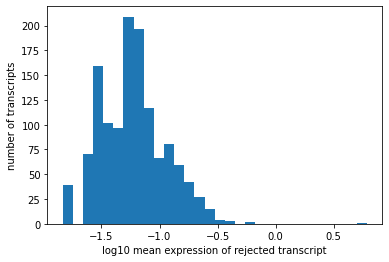

In [42]:
plt.hist(np.log10(rej_badfit_mean),30)
plt.xlabel('log10 mean expression of rejected transcript')
plt.ylabel('number of transcripts')

In [43]:
genes_rej

1

In [44]:
n_transc

4362

In [45]:
rej_badfit 

1290

In [46]:
rej_underdisp

732

In [47]:
rej_construction 

11

Quantify how many correlations accord and fail to accord with theoretical limits.

In [48]:
np.sum(CORR_THEO > CORR_TRUE)

11894

In [49]:
len(CORR_THEO)

12480

In [50]:
np.sum(CORR_THEO < CORR_TRUE)

586

Plot the correlations.

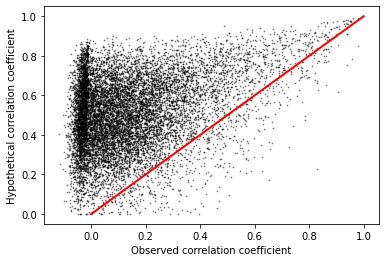

In [51]:
plt.plot(CORR_TRUE,CORR_THEO,'k.',alpha=0.5,markersize=1.3)
plt.plot([0,1],[0,1],'r-',linewidth=2)
plt.box('off')
plt.xlabel("Observed correlation coefficient")
plt.ylabel("Hypothetical correlation coefficient")
plt.savefig('corrcoef.png',dpi=600)

We can now look under the hood and investigate how the exon graphs look.

In [52]:
df_gene = df_a[df_a['gene_name']=='Rps13']
data_X = np.asarray([df_gene.iloc[i,3:] for i in roots],dtype=float)

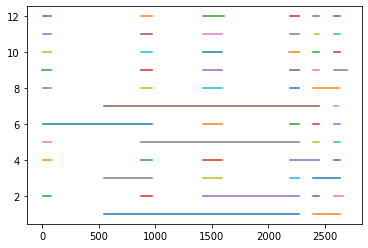

In [53]:
exons = compile_exons(df_gene,db,plot=True)

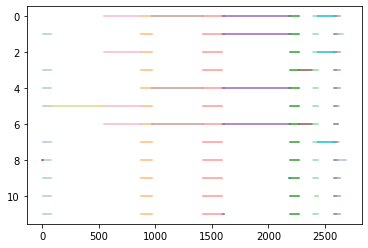

In [54]:
transcript_interval_map = construct_transcript_interval_map(exons,plot=True)

This transcript interval map implies a reachability DAG (or equivalent transitive reduction), with the "root" transcripts marked in red. These cannot be reached from any other transcript, and must be produced by disjoint processes from the source transcript.

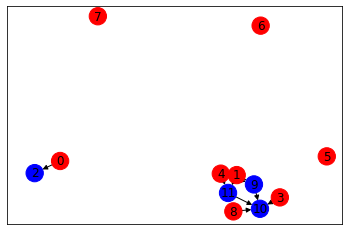

In [55]:
G=construct_dag(transcript_interval_map)
roots = [i for i in G.nodes() if G.in_degree(i)==0]
colors = ['r' if i in roots else 'b' for i in  G.nodes()  ]
nx.draw_networkx(G,node_color=colors)